<a href="https://colab.research.google.com/github/Kymapo/AMATH581/blob/main/AMATH581HW6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[[ 24.94003847+0.00000000e+00j  12.73268299+2.38029692e-15j
   -1.38095598+3.44277620e-15j ... -64.02389647-4.71738616e-14j
  -67.76356741-4.08015999e-14j -61.18058974-3.42492979e-14j]
 [-18.55666362-5.81663109e+01j -42.51586944-4.69129224e+01j
  -60.80795253-2.57480390e+01j ... -26.39439597+1.13082890e+02j
    6.86544434+1.23000456e+02j  41.4436393 +1.10055312e+02j]
 [-16.04755868+3.28279829e+01j -22.03971648-4.57977740e+01j
  -23.23089505-1.04141716e+02j ... -25.03391682-9.26527314e+01j
  -29.2936105 -4.09594873e+01j -31.3712619 +1.56986891e+01j]
 ...
 [ 24.73021466-5.66774723e+02j  34.94179045-3.31372917e+02j
   38.82924248-4.97842318e+01j ...   4.99619196+6.02396295e+02j
   -9.93322885+4.90736906e+02j -25.6299042 +2.81792021e+02j]
 [ 25.33720124-3.61633792e+02j  43.00958768-4.53711746e+02j
   51.93221654-4.47841562e+02j ... -30.76392977+2.66442187e+02j
  -58.45411318+4.29165358e+02j -74.0191717 +5.05315322e+02j]
 [ -6.4753501 +3.96245454e+01j  15.86720969-5.83358549e+01j
   37.7389

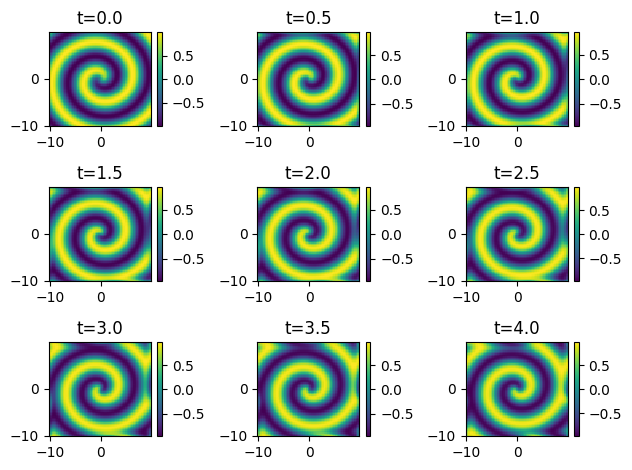

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft2, ifft2
from scipy.integrate import solve_ivp

# Parameters
Lx, Ly = 20, 20
nx, ny = 64, 64  # Grid size
beta = 1
D1, D2 = 0.1, 0.1  # Diffusion coefficients
tspan = np.linspace(0, 4, 9)  # Time points
x2 = np.linspace(-Lx / 2, Lx / 2, nx + 1)
x = x2[:nx]
y2 = np.linspace(-Ly / 2, Ly / 2, ny + 1)
y = y2[:ny]
X, Y = np.meshgrid(x, y)


m = 1
# Initial Conditions: One-armed spiral
u0 = np.tanh(np.sqrt(X**2 + Y**2)) * np.cos(m * np.angle(X + 1j * Y) - np.sqrt(X**2 + Y**2))
u0t = fft2(u0)
v0 = np.tanh(np.sqrt(X**2 + Y**2)) * np.sin(m * np.angle(X + 1j * Y) - np.sqrt(X**2 + Y**2))
v0t = fft2(v0)

# Combine U and V into a single vector
uv0t = np.hstack((u0t.flatten(), v0t.flatten()))

# Define wave numbers for FFT
kx = (2 * np.pi / Lx) * np.concatenate((np.arange(0, nx/2), np.arange(-nx/2, 0)))
#kx[0] = 1e-6
ky = (2 * np.pi / Ly) * np.concatenate((np.arange(0, ny/2), np.arange(-ny/2, 0)))
#ky[0] = 1e-6
KX, KY = np.meshgrid(kx, ky)
K2 = KX**2 + KY**2


# Reaction-Diffusion RHS
def reaction_diffusion_rhs(t, uv, nx, ny, K2, beta, D1, D2):
    u_t, v_t = uv[:nx*ny].reshape((nx, ny)), uv[nx*ny:].reshape((nx, ny))

    # Fourier transforms
    u = ifft2(u_t)
    v = ifft2(v_t)

    A = u**2 + v**2
    lambda_A = 1 - A
    omega_A = -beta * A


    # Combine reaction and diffusion
    rhs_u = D1 * (-K2 * u_t) + fft2(lambda_A * u - omega_A * v)
    rhs_v = D2 * (-K2 * v_t) + fft2(omega_A * u + lambda_A * v)

    return np.hstack((rhs_u.flatten(), rhs_v.flatten()))

# Solve the system
solution = solve_ivp(
    reaction_diffusion_rhs, [tspan[0], tspan[-1]], uv0t,
    args=(nx, ny, K2, beta, D1, D2), t_eval=tspan, method='RK45'
)

# Extract results
uv_sol = solution.y
elapsed_time = solution.message


A1 = uv_sol
print(A1)

# Plot results
for i, t in enumerate(tspan):
    u = np.real(ifft2(uv_sol[:nx*ny, i].reshape((nx, ny))))
    plt.subplot(3, 3, i + 1)
    plt.pcolor(X, Y, u, shading='auto')
    plt.colorbar()
    plt.title(f't={t}')

plt.tight_layout()
plt.show()


[[ 0.70358468  0.27678435 -0.21775865 ... -0.79689015 -0.40972859
   0.07776933]
 [ 0.73241275  0.47188952  0.07344742 ... -0.96577657 -0.78500366
  -0.4261521 ]
 [ 0.81058026  0.37605887 -0.11123233 ... -0.84008598 -0.49565779
  -0.03085913]
 ...
 [ 0.58562756  0.91352592  0.97914313 ... -0.50294695 -0.84298442
  -0.97634716]
 [ 0.6808609   0.87018536  0.97997159 ... -0.16453512 -0.5878894
  -0.88455009]
 [ 0.71061143  0.96093661  0.97601586 ... -0.60413504 -0.91222169
  -0.99697897]]


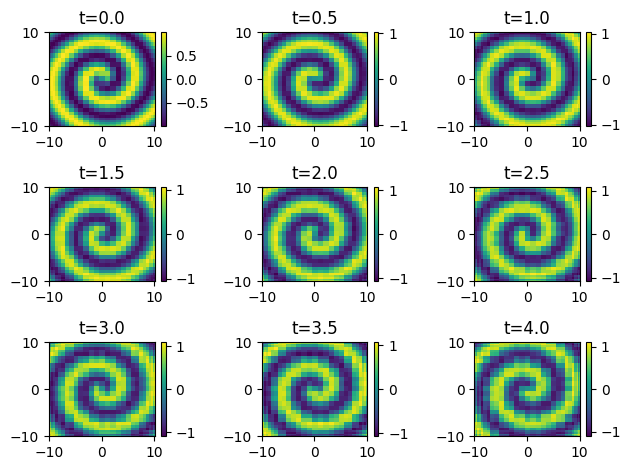

In [4]:
import numpy as np
from scipy.linalg import block_diag
from scipy.integrate import solve_ivp
from scipy.linalg import kron
import matplotlib.pyplot as plt

# Chebyshev differentiation function
def cheb(N):
    if N == 0:
        D = np.array([[0.]]); x = np.array([1.])
    else:
        n = np.arange(0, N + 1)
        x = np.cos(np.pi * n / N).reshape(N + 1, 1)
        c = (np.hstack(([2.], np.ones(N - 1), [2.])) * (-1)**n).reshape(N + 1, 1)
        X = np.tile(x, (1, N + 1))
        dX = X - X.T
        D = np.dot(c, 1. / c.T) / (dX + np.eye(N + 1))
        D -= np.diag(np.sum(D.T, axis=0))
    return D, x.flatten()

# Parameters
N = 30  # Number of Chebyshev grid points
beta = 1
D1, D2 = 0.1, 0.1  # Diffusion coefficients
tspan = np.linspace(0, 4, 9)

# Chebyshev grid and differentiation matrix
D, x = cheb(N)
D[N, :] = 0  # Enforce no-flux at the boundary (Neumann BCs)
D[0, :] = 0
Dxx = np.dot(D, D) / (20 / 2)**2  # Scaling for new domain
y = x  # Chebyshev grid for y-direction (same as x)

N2 = (N+1)**2
# Identity matrix
I = np.eye(len(Dxx))

# 2D Laplacian
L = kron(I, Dxx) + kron(Dxx, I)

# Initial conditions: One-armed spiral
X, Y = np.meshgrid(x, y)
X = X * (20 / 2) # scaling for new domain
Y = Y * (20 / 2)
m = 1
u0 = np.tanh(np.sqrt(X**2 + Y**2)) * np.cos(m * np.angle(X + 1j * Y) - np.sqrt(X**2 + Y**2))
v0 = np.tanh(np.sqrt(X**2 + Y**2)) * np.sin(m * np.angle(X + 1j * Y) - np.sqrt(X**2 + Y**2))
uv0 = np.concatenate([u0.flatten(), v0.flatten()])

# Reaction-Diffusion RHS
def reaction_diffusion_rhs(t, uv, L, beta, D1, D2, N):
    u, v = uv[:(N + 1)**2], uv[(N + 1)**2:]
    u = u.reshape((N + 1, N + 1))
    v = v.reshape((N + 1, N + 1))

    A2 = u**2 + v**2
    lambda_A = 1 - A2
    omega_A = -beta * A2

    # Reaction terms
    u_react = lambda_A * u - omega_A * v
    v_react = omega_A * u + lambda_A * v

    # Diffusion terms (using 2D Laplacian)
    u_diff = D1 * L @ u.flatten()
    v_diff = D2 * L @ v.flatten()

    # Combine
    u_t = u_react.flatten() + u_diff
    v_t = v_react.flatten() + v_diff

    return np.concatenate([u_t, v_t])

# Solve system
solution = solve_ivp(
    reaction_diffusion_rhs, [tspan[0], tspan[-1]], uv0,
    args=(L, beta, D1, D2, N), t_eval=tspan, method='RK45'
)

# Extract results
uv_sol = solution.y

A2 = uv_sol
print(A2)
for i, t in enumerate(tspan):
    u = uv_sol[:(N + 1)**2, i].reshape((N + 1, N + 1))
    plt.subplot(3, 3, i + 1)
    plt.pcolor(X, Y, u, shading='auto')
    plt.colorbar()
    plt.title(f't={t}')

plt.tight_layout()
plt.show()
